# Multilabel classification with BERT
1. Goal
  - Build a model that predicts tags (keywords) of articles published on arxiv.
  - Compare different solutions for class imbalance problem and multilabel classification problem. Specifically: 
    - Sampling methods: LPROS vs. MLROS. 
    - Multilabel classification: binary relevance vs. classifier chain vs. KNN vs. deep learning)

2. Data: https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts?select=arxiv_data.csv

3. Class Imbalance
  - The dataset is imbalanced when the occurrence of each label is not equal. In the current notebook, I used the label powerset random oversampling and multilabel random oversampling methods. The LPROS and MLROS approaches are chosen because two methods outperformed other techniques in a recent article ([Terekegn et al., 2021](https://www.sciencedirect.com/science/article/pii/S0031320321001527))

4. BERT
  - Bidirectional Encoder Representations from Transformers (BERT) is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google ([Devlin et al., 2018](https://arxiv.org/abs/1810.04805)). A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data.

5. Binary Relevance vs. Classifier Chain
  - Binary relevance approach works by building an independent binary classifier for each class. 
  - Classifier chain approach works by buidling a binary classifier for each class. The classifier for class i uses predictions from classifier class j where i > j. 

6. MLKNN
  - ML-KNN is derived from the traditional K-nearest neighbor (KNN) algorithm. For each unseen
instance, its K nearest neighbors in the training set are firstly identified. After that, based on information gained from the label sets of
these neighboring instances, maximum a posteriori (MAP) principle
is utilized to determine the label set for the unseen instance ([Zhang & Zhou, 2007](https://www.sciencedirect.com/science/article/pii/S0031320307000027)).


 

## Setup

In [1]:
# To run KNN
# !pip uninstall scikit-learn -y
# !pip install scikit-learn==0.24.1
import sklearn
sklearn.__version__

'1.0.2'

In [2]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
     |████████████████████████████████| 895 kB 39.0 MB/s 
     |████████████████████████████████| 6.8 MB 29.1 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 3.8 MB/s 
     |████████████████████████████████| 1.2 MB 34.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=dc3ff848f8e82647f01e3cd1bec627b54370d91fff3d25ab1d9f28d3415727b3
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers


In [4]:
!pip install scikit-multilearn

     |████████████████████████████████| 89 kB 4.1 MB/s 


In [5]:
# Import packages
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score
from sentence_transformers import SentenceTransformer
from skmultilearn.problem_transform import ClassifierChain
# import torch
# import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import scipy.sparse
from sklearn.pipeline import Pipeline
# from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, hamming_loss
import joblib

In [6]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from ast import literal_eval
import matplotlib.pyplot as plt

## Import Data

### Kaggle

In [7]:
# Import data
!pip install kaggle

In [8]:
!mkdir ~/.kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joonkim2020","key":"526021edb67fd4cfcf569b34a6d068d4"}'}

In [10]:
!cp kaggle.json ~/.kaggle/

In [11]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d spsayakpaul/arxiv-paper-abstracts

 92% 41.0M/44.6M [00:00<00:00, 66.5MB/s]
100% 44.6M/44.6M [00:00<00:00, 90.9MB/s]


In [13]:
!unzip arxiv-paper-abstracts.zip -d kaggle

Archive:  arxiv-paper-abstracts.zip
  inflating: kaggle/arxiv_data.csv   
  inflating: kaggle/arxiv_data_210930-054931.csv  


In [14]:
df = pd.read_csv("/content/kaggle/arxiv_data.csv")

In [15]:
print(df.shape)
df.head()

(51774, 3)


,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


In [16]:
total_duplicate_titles = sum(df["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


In [17]:
df = df[~df["titles"].duplicated()]
print(f"There are {len(df)} rows in the clean dataset.")
# Select samples
df = df.sample(n = 5000, random_state = 1)
# Choose the column 
df = df[["summaries", "terms"]]

There are 38972 rows in the clean dataset.


## Binary Relevance, Classifier Chain, MLKNN 
### Preprocessing

#### Filtering

In [ ]:
# Convert list of strings to lists 
df['terms'] = df['terms'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# Calculate the number of unique keywords in "Terms" column
print(df['terms'].explode().value_counts()[0:10])
print("Number of unique terms:", len(df['terms'].explode().unique()))

cs.CV      2854
cs.LG      2826
stat.ML    1573
cs.AI       729
eess.IV     214
cs.RO       208
cs.CL       138
cs.NE       136
cs.CR        77
math.OC      77
Name: terms, dtype: int64
Number of unique terms: 273


In [ ]:
# Choose top 5 keywords 
from collections import Counter
top_terms_list = Counter(list(df['terms'].explode())).most_common(5)
top_terms = [a_tuple[0] for a_tuple in top_terms_list]
top_terms

['cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV']

In [ ]:
df['terms'].head()

1342                                               [cs.CV]
19326                                       [cs.CV, cs.AI]
22098    [cs.LG, physics.app-ph, physics.chem-ph, physi...
48541                                [cs.LG, cs.AI, cs.SE]
12544                                       [cs.CV, cs.LG]
Name: terms, dtype: object

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
# Filter out records that have at least one of the top keywords
x = [] # To store the filtered text (features)
y = [] # to store the corresponding terms (labels)

for i in range(len(df['terms'])):
    temp = []
    for term in df['terms'][i]:
        if term in top_terms:
            temp.append(term)

    if(len(temp)>0):
        x.append(df['summaries'][i])
        y.append(temp)

#### One Hot Encoding: Individual Labels

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer() 
yt = mlb.fit_transform(y)
yt.shape

(5000, 5)

In [ ]:
yt

array([[0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0]])

In [ ]:
# build a dataframe with the feature (text) and labels 
df_filtered = pd.DataFrame()
df_filtered['text'] = x
df_labels = pd.DataFrame(yt, columns = top_terms)
df_filtered = pd.concat([df_filtered, df_labels], axis = 1)

#### Label Powerset 

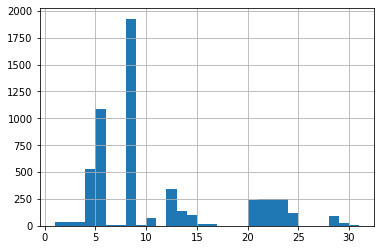

In [ ]:
# Add label powerset 
df_filtered['powerlabel'] = df_filtered.apply(lambda x : 16*x['cs.CV']+8*x['cs.LG']+4*x['stat.ML']+2*x['cs.AI']+1*x['eess.IV'],axis=1)

# Create a histogram to confirm data imbalance 
df_filtered['powerlabel'].hist(bins=np.unique(df_filtered['powerlabel']))

In [ ]:
df_filtered.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,"This report describes the design, implementati...",0,1,0,0,0,8
1,Recent advances in document image analysis (DI...,1,1,0,0,0,24
2,Bayesian optimization (BO) is a popular paradi...,0,0,1,0,0,4
3,Learning algorithms produce software models fo...,1,0,1,0,0,20
4,Capsules are the name given by Geoffrey Hinton...,0,1,1,0,0,12


#### Train-test split

In [ ]:
train, test = train_test_split(df_filtered, test_size = 0.3, random_state = 1)
train = train.reset_index(drop = True)

In [ ]:
train.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,Today deep convolutional neural networks (CNNs...,0,1,0,0,0,8
1,"In the paper, we propose a class of efficient ...",0,0,1,0,1,5
2,The generative adversarial network (GAN) exhib...,0,1,1,1,0,14
3,Though convolutional neural networks are widel...,1,1,0,0,0,24
4,"In recent years, advances in the development o...",0,1,0,0,0,8


#### LP-ROS (Label Powerset Random Oversampling)
- The Label Powerset transformation method transforms the multilabel data into a multi-class dataset, processing each different combination of labels (label-set) as a class. In other words, label powerset approach converts a multilabel classification problem into a multiclass classification problem. 
- LP-ROS (Label Powerset Random Over Sampling) is a multi-label random oversampling method that works by cloning random samples of minority label-sets until the size of the multilabel data increases by the prespecified percentage.  
- In this notebook, we set the number of minority labels to equal to the number of the majority label. 
- Reference: [Imbalanced Multilabel Scene Classification using Keras](https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b) 

In [ ]:
train_lpros = train.copy()

In [ ]:
powercount = {}
powerlabels = np.unique(train['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(train['powerlabel'] == p)

maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    #print(gapnum)
    temp_df = train.iloc[np.random.choice(np.where(train['powerlabel'] == p)[0], size = gapnum)]
    train_lpros = train_lpros.append(temp_df, ignore_index=True)
    
#train_lpros = train.sample(frac = 1).reset_index(drop=True)

In [ ]:
train_lpros.shape

(29414, 7)

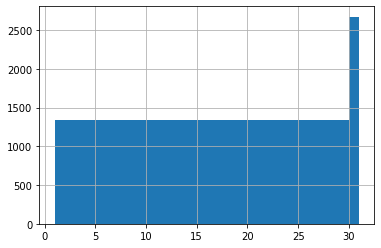

In [ ]:
# The graph is incorrect - the height of the bar for label 30 doesn't match the number of labels.
train_lpros['powerlabel'].hist(bins=np.unique(train_lpros['powerlabel']))

In [ ]:
powercount_lpros = {}
powerlabels = np.unique(train['powerlabel'])
for p in powerlabels:
    powercount_lpros[p] = np.count_nonzero(train_lpros['powerlabel'] == p)
powercount_lpros

{1: 1337,
 4: 1337,
 5: 1337,
 6: 1337,
 7: 1337,
 8: 1337,
 9: 1337,
 10: 1337,
 11: 1337,
 12: 1337,
 13: 1337,
 14: 1337,
 15: 1337,
 17: 1337,
 20: 1337,
 21: 1337,
 24: 1337,
 25: 1337,
 28: 1337,
 29: 1337,
 30: 1337,
 31: 1337}

#### ML-ROS (Multilabel Random Oversampling)

- ML-ROS is an approach based on the frequency of individual labels, instead of the full label-sets. 
- ML-ROS relies on IRLbl (imbalance ratio per label) and MeanIR (mean imbalance ratio) measures. Labels whose IRLbl is greater than MeanIR are considered to be minority labels, while labels whose IRLbl is smaller than MeanIR can be considered to be majority labels.
- In the current notebook, we use the ML-ROS technique that uses IRLbl and MeanIR to identify majority and minority labels ([Charte, 2018](https://arxiv.org/pdf/1802.05031.pdf)). 

In [ ]:
# calculate Mean IR and IRLbl
def IRLbl(labels):
  """
  imbalance ratio per label: (the number of instances of majority label) / (the number of instances of a specific label)
  labels is a 2d numpy array, each row is one instance, each column is one class; the array contains (0, 1) only
  """
  N, C = labels.shape
  pos_nums_per_label = np.sum(labels, axis = 0)
  max_pos_nums = np.max(pos_nums_per_label)
  return max_pos_nums / pos_nums_per_label

def MeanIR(labels):
  """
  The mean of imbalance ratio
  """
  IRLbl_VALUE = IRLbl(labels)
  return np.mean(IRLbl_VALUE)

In [ ]:
import random

def ML_ROS(df, labels, max_clone_percentage=50):
  """
  Algorithm: https://arxiv.org/pdf/1802.05031.pdf
  Reference: https://github.com/Bupenieks/ImbalancedMLC/blob/master/dataset_metrics.ipynb  
  """
  # N of samples to clone, obtain the set of labels
  labels_df = df[labels]
  N, C = labels_df.shape
  num_samples_to_clone = N / 100 * max_clone_percentage
  print('Number of samples to clone:', num_samples_to_clone)

  # for each label, add samples to the minority bag if the IRLbl < MeanIR
  minority_classes = []
  MeanIR_value = MeanIR(labels_df)
  IRLbl_value = IRLbl(labels_df)

  df_idx = df.index
  map = {}
  for l in labels:
    l_indices = df_idx[df[l] == 1].tolist()
    map[l] = l_indices
    min_bags = {l:ins for l, ins in map.items() if IRLbl_value[l] > MeanIR_value}
  print('Minority label:', min_bags.keys())

  # Clone a random sample from each minority bag
  new_df = df
  while num_samples_to_clone > 0:
    for l in min_bags:
      instance_to_clone = random.choice(min_bags[l])
      new_df = new_df.append(df.iloc[instance_to_clone])
      new_IRs = IRLbl(new_df[labels])
      new_IR_l = new_IRs[l]

    if new_IR_l <= MeanIR_value:
      # Exclude from cloning
      del min_bags[l]
                        
    num_samples_to_clone -= 1

    if len(min_bags.keys()) == 0:
      print("Unable to clone all samples. {} left to clone".format(num_samples_to_clone))
      break

  return new_df

In [ ]:
labels = ['cs.CV',	'cs.LG',	'stat.ML',	'cs.AI',	'eess.IV']
train_mlros = ML_ROS(train, labels)

Number of samples to clone: 1750.0
Minority label: dict_keys(['cs.AI'])
Unable to clone all samples. 1320.0 left to clone


In [ ]:
train_mlros.shape

(3930, 7)

In [ ]:
print(MeanIR(train[labels]))
IRLbl(train[labels])

4.139988862143587


cs.CV       3.875486
cs.LG       1.000000
stat.ML     1.000502
cs.AI      13.019608
eess.IV     1.804348
dtype: float64

In [ ]:
print(MeanIR(train_mlros[labels]))
IRLbl(train_mlros[labels])

2.5767488120208695


cs.CV      4.583650
cs.LG      1.000000
stat.ML    1.062583
cs.AI      4.135506
eess.IV    2.102005
dtype: float64

In [ ]:
train_lpros.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,Today deep convolutional neural networks (CNNs...,0,1,0,0,0,8
1,"In the paper, we propose a class of efficient ...",0,0,1,0,1,5
2,The generative adversarial network (GAN) exhib...,0,1,1,1,0,14
3,Though convolutional neural networks are widel...,1,1,0,0,0,24
4,"In recent years, advances in the development o...",0,1,0,0,0,8


In [ ]:
train_mlros.head()

,text,cs.CV,cs.LG,stat.ML,cs.AI,eess.IV,powerlabel
0,Today deep convolutional neural networks (CNNs...,0,1,0,0,0,8
1,"In the paper, we propose a class of efficient ...",0,0,1,0,1,5
2,The generative adversarial network (GAN) exhib...,0,1,1,1,0,14
3,Though convolutional neural networks are widel...,1,1,0,0,0,24
4,"In recent years, advances in the development o...",0,1,0,0,0,8


#### Embeddings: BERT

In [ ]:
# Generate embeddings
model = SentenceTransformer('multi-qa-distilbert-dot-v1')
def bert_embeddings(col):
  sentences = list(col)
  sentence_embeddings = model.encode(sentences)
  sentence_embeddings_df = pd.DataFrame(sentence_embeddings)
  return sentence_embeddings_df

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
X_train_mlros = bert_embeddings(train_mlros['text'])
y_train_mlros = train_mlros[labels]

In [ ]:
# takes 4 minutes 
X_train_lpros = bert_embeddings(train_lpros['text'])
y_train_lpros = train_lpros[labels]

In [ ]:
X_train = bert_embeddings(train['text'])
y_train = train[labels]

In [ ]:
X_test = bert_embeddings(test['text'])
y_test = test[labels]

KeyboardInterrupt: ignored

### Model
- Binary Relevance
- Classifier Chain
- [Multilabel K-Nearest Neighbors](http://scikit.ml/api/skmultilearn.adapt.mlknn.html): "uses k-NearestNeighbors find nearest examples to a test class and uses Bayesian inference to select assigned labels."



### Classifier Chain

In [ ]:
def cc_lr_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = ClassifierChain(LogisticRegression())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

In [ ]:
# using classifier chain + naive bayes
def cc_nb_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = ClassifierChain(GaussianNB())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

### Binary Relevance

In [ ]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

def br_nb_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = BinaryRelevance(GaussianNB())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

In [ ]:
# using binary relevance + logistic regression
def br_lr_fit(X_train, y_train, X_test):
  # initialize classifier chains multi-label classifier
  classifier = BinaryRelevance(LogisticRegression())

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

### KNN

In [ ]:
# KNN
# for "TypeError: __init__() takes 1 positional argument but 2 were given", install the old version of sklearn
# !pip uninstall scikit-learn -y
# !pip install scikit-learn==0.24.1

from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

def mlknn_fit(X_train, y_train, X_test, parameters, score):
  # initialize classifier chains multi-label classifier

  clf = GridSearchCV(MLkNN(), parameters, scoring=score)
  clf.fit(X_train, y_train)

  print (clf.best_params_, clf.best_score_)
  k = clf.best_params_['k']
  classifier = MLkNN(k)

  # Training logistic regression model on train data
  classifier.fit(X_train, y_train)

  # predict
  predictions = classifier.predict(X_test)
  y_pred = pd.DataFrame.sparse.from_spmatrix(predictions)

  return classifier, y_pred

### Fitting

In [ ]:
cc_lr_raw, y_pred_cc_lr_raw = cc_lr_fit(X_train, y_train, X_test)
cc_nb_raw, y_pred_cc_nb_raw = cc_nb_fit(X_train, y_train, X_test)
br_lr_raw, y_pred_br_lr_raw = br_lr_fit(X_train, y_train, X_test)
br_nb_raw, y_pred_br_nb_raw = br_nb_fit(X_train, y_train, X_test)

NameError: ignored

In [ ]:
cc_lr_mlros, y_pred_cc_lr_mlros = cc_lr_fit(X_train_mlros, y_train_mlros, X_test)
cc_nb_mlros, y_pred_cc_nb_mlros = cc_nb_fit(X_train_mlros, y_train_mlros, X_test)
br_lr_mlros, y_pred_br_lr_mlros = br_lr_fit(X_train_mlros, y_train_mlros, X_test)
br_nb_mlros, y_pred_br_nb_mlros = br_nb_fit(X_train_mlros, y_train_mlros, X_test)

In [ ]:
cc_lr_lpros, y_pred_cc_lr_lpros = cc_lr_fit(X_train_lpros, y_train_lpros, X_test)
cc_nb_lpros, y_pred_cc_nb_lpros = cc_nb_fit(X_train_lpros, y_train_lpros, X_test)
br_lr_lpros, y_pred_br_lr_lpros = br_lr_fit(X_train_lpros, y_train_lpros, X_test)
br_nb_lpros, y_pred_br_nb_lpros = br_nb_fit(X_train_lpros, y_train_lpros, X_test)

In [ ]:
# To use the mlknn package, the dataset should be converted to a sparse matrix.
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)
y_train_sparse = scipy.sparse.csr_matrix(y_train.values)
X_train_mlros_sparse = scipy.sparse.csr_matrix(X_train_mlros.values)
y_train_mlros_sparse = scipy.sparse.csr_matrix(y_train_mlros.values)
#X_train_lpros_sparse = scipy.sparse.csr_matrix(X_train_lpros.values)
#y_train_lpros_sparse = scipy.sparse.csr_matrix(y_train_lpros.values)

In [ ]:
parameters = {'k': range(1, 6)}
score = 'f1_macro'
mlknn_raw, y_pred_mlknn_raw = mlknn_fit(X_train_sparse, y_train_sparse, X_test, parameters, score)
mlknn_mlros, y_pred_mlknn_mlros = mlknn_fit(X_train_mlros_sparse, y_train_mlros_sparse, X_test, parameters, score)
# mlknn_lpros, y_pred_mlknn_lpros = mlknn_fit(X_train_lpros_sparse, y_train_lpros_sparse, X_test) # takes 25 minutes 

{'k': 4} 0.5401080482716188
{'k': 1} 0.6715479930981452


## Compare Results 
- Evaluation metrics for classification problem
  - Accuracy: number of correct predictions / total predictions. The accuracy could be misleading when the dataset is not balanced. For example, if there are four positives and one negative, the model that predicts all samples to be positive achieves 80% accuracy. 
  - Precision: true positives divided by the number of samples that were predicted to be positive. TP / (TP + FP)
  - Recall: true positives divided by true positives + false negatives. TP / (TP + FN)
  - The F1 score is the harmonic mean of the precision and recall. 2*(precision *  recall) / (precision + recall). 
  - Macro average: simple average of all classes. For example, if there are three classes, the macro average for precision is the average of precision of class A, precision of class B, and precision of class C.  
  - Micro average: this is calculated by considering all true positives, false positives, and false negatives. For example, the micro average for precision is: sum of true positives (across three classes) / sum of true positives + sum of false positives 
  - Weighted average: average of the metric values weighted by the support of that class. For example: Precision of class A * Support of class A + Precision of class B * Support of class B / (Support of class A + Support of class B) 
  - [Hamming Loss](https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd): computes the proportion of incorrectly predicted labels to the total number of labels. For a multilabel classification, we compute the number of False Positives and False Negative per instance and then average it over the total number of training instances. $\frac{1}{|N|*|L|}\sum_{i=1}^N \sum_{j=1}^L xor(y_{i,j}, z_{i,j})$. Where N is the number of samples, L is the number of classes, $y_{ij}$ is the true label, $z_{ij}$ is the predicted label, and xor is the operator that returns zero if the prediction and the true label are the same. The optimal value for the hamming loss is zero.   



In [ ]:
def results(y_test, y_pred, labels, X_train, X_test):
  print(classification_report(y_test, y_pred, target_names=labels))
  print("Training Dataset Count", X_train.shape[0])
  print("Test Dataset Count", X_test.shape[0])
  print("Weighted Precision", precision_score(y_test, y_pred, average='weighted'))
  print("Weighted Recall", recall_score(y_test, y_pred, average='weighted'))
  print("Weighted F1", f1_score(y_test, y_pred, average='weighted'))
  print("Accuracy", accuracy_score(y_test, y_pred))
  print("Hamming Loss", hamming_loss(y_test, y_pred))


#### Raw data

In [ ]:
# Classification report for raw data (imbalanced data) 
results(y_test, y_pred_cc_lr_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.39      0.27      0.31       200
       cs.LG       0.92      0.90      0.91       879
     stat.ML       0.84      0.80      0.82       858
       cs.AI       0.18      0.09      0.12        82
     eess.IV       0.63      0.65      0.64       459

   micro avg       0.79      0.74      0.76      2478
   macro avg       0.59      0.54      0.56      2478
weighted avg       0.77      0.74      0.75      2478
 samples avg       0.84      0.80      0.78      2478

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7699776101138152
Weighted Recall 0.7425343018563357
Weighted F1 0.7545364535367935
Accuracy 0.4886666666666667
Hamming Loss 0.15106666666666665


In [ ]:
results(y_test, y_pred_cc_nb_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.30      0.57      0.39       200
       cs.LG       0.94      0.89      0.92       879
     stat.ML       0.90      0.77      0.83       858
       cs.AI       0.13      0.52      0.21        82
     eess.IV       0.59      0.82      0.69       459

   micro avg       0.68      0.80      0.73      2478
   macro avg       0.57      0.72      0.61      2478
weighted avg       0.78      0.80      0.78      2478
 samples avg       0.73      0.85      0.74      2478

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7840681172132579
Weighted Recall 0.8010492332526231
Weighted F1 0.7796446287364394
Accuracy 0.342
Hamming Loss 0.19133333333333333


In [ ]:
results(y_test, y_pred_br_lr_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.39      0.27      0.31       200
       cs.LG       0.92      0.90      0.91       879
     stat.ML       0.83      0.82      0.82       858
       cs.AI       0.20      0.10      0.13        82
     eess.IV       0.64      0.59      0.62       459

   micro avg       0.79      0.74      0.76      2478
   macro avg       0.59      0.54      0.56      2478
weighted avg       0.77      0.74      0.75      2478
 samples avg       0.83      0.80      0.78      2478

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7691543343206935
Weighted Recall 0.7380952380952381
Weighted F1 0.7519534143306252
Accuracy 0.46266666666666667
Hamming Loss 0.1512


In [ ]:
results(y_test, y_pred_br_nb_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.30      0.57      0.39       200
       cs.LG       0.94      0.90      0.92       879
     stat.ML       0.89      0.78      0.83       858
       cs.AI       0.14      0.50      0.21        82
     eess.IV       0.61      0.81      0.69       459

   micro avg       0.69      0.80      0.74      2478
   macro avg       0.57      0.71      0.61      2478
weighted avg       0.78      0.80      0.78      2478
 samples avg       0.74      0.85      0.75      2478

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7833807136281062
Weighted Recall 0.8006456820016142
Weighted F1 0.7808391277374717
Accuracy 0.3526666666666667
Hamming Loss 0.18653333333333333


In [ ]:
results(y_test, y_pred_mlknn_raw, labels, X_train, X_test)

              precision    recall  f1-score   support

       cs.CV       0.38      0.18      0.24       200
       cs.LG       0.89      0.91      0.90       879
     stat.ML       0.85      0.81      0.83       858
       cs.AI       0.00      0.00      0.00        82
     eess.IV       0.64      0.53      0.58       459

   micro avg       0.81      0.72      0.76      2478
   macro avg       0.55      0.49      0.51      2478
weighted avg       0.76      0.72      0.73      2478
 samples avg       0.85      0.79      0.78      2478

Training Dataset Count 3500
Test Dataset Count 1500
Weighted Precision 0.7569212596054808
Weighted Recall 0.7163034705407587
Weighted F1 0.7325096660118093
Accuracy 0.47333333333333333
Hamming Loss 0.1504


#### MLROS

In [ ]:
results(y_test, y_pred_cc_lr_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.37      0.26      0.31       200
       cs.LG       0.91      0.91      0.91       879
     stat.ML       0.83      0.80      0.81       858
       cs.AI       0.18      0.20      0.19        82
     eess.IV       0.63      0.66      0.65       459

   micro avg       0.77      0.75      0.76      2478
   macro avg       0.58      0.57      0.57      2478
weighted avg       0.76      0.75      0.75      2478
 samples avg       0.82      0.81      0.77      2478

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7629232965550286
Weighted Recall 0.7489911218724778
Weighted F1 0.7549741888714908
Accuracy 0.47
Hamming Loss 0.1576


In [ ]:
results(y_test, y_pred_cc_nb_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.28      0.59      0.38       200
       cs.LG       0.94      0.89      0.91       879
     stat.ML       0.89      0.79      0.84       858
       cs.AI       0.12      0.52      0.20        82
     eess.IV       0.59      0.84      0.69       459

   micro avg       0.67      0.81      0.73      2478
   macro avg       0.57      0.73      0.60      2478
weighted avg       0.78      0.81      0.78      2478
 samples avg       0.72      0.85      0.74      2478

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7786040748847425
Weighted Recall 0.8083131557707829
Weighted F1 0.7796352817584219
Accuracy 0.3233333333333333
Hamming Loss 0.1972


In [ ]:
results(y_test, y_pred_br_lr_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.40      0.28      0.33       200
       cs.LG       0.91      0.91      0.91       879
     stat.ML       0.82      0.82      0.82       858
       cs.AI       0.18      0.21      0.19        82
     eess.IV       0.63      0.58      0.60       459

   micro avg       0.77      0.74      0.76      2478
   macro avg       0.59      0.56      0.57      2478
weighted avg       0.76      0.74      0.75      2478
 samples avg       0.82      0.80      0.77      2478

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7624700446322856
Weighted Recall 0.7429378531073446
Weighted F1 0.7515852513181339
Accuracy 0.448
Hamming Loss 0.15813333333333332


In [ ]:
results(y_test, y_pred_br_nb_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.28      0.59      0.38       200
       cs.LG       0.94      0.89      0.92       879
     stat.ML       0.87      0.80      0.83       858
       cs.AI       0.12      0.48      0.19        82
     eess.IV       0.60      0.82      0.69       459

   micro avg       0.67      0.81      0.73      2478
   macro avg       0.56      0.71      0.60      2478
weighted avg       0.77      0.81      0.78      2478
 samples avg       0.72      0.85      0.74      2478

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7736267476740205
Weighted Recall 0.8075060532687651
Weighted F1 0.7785636593356672
Accuracy 0.32466666666666666
Hamming Loss 0.19506666666666667


In [ ]:
results(y_test, y_pred_mlknn_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.34      0.33       200
       cs.LG       0.85      0.88      0.86       879
     stat.ML       0.81      0.79      0.80       858
       cs.AI       0.20      0.13      0.16        82
     eess.IV       0.56      0.53      0.55       459

   micro avg       0.72      0.72      0.72      2478
   macro avg       0.55      0.54      0.54      2478
weighted avg       0.72      0.72      0.72      2478
 samples avg       0.78      0.77      0.74      2478

Training Dataset Count 3929
Test Dataset Count 1500
Weighted Precision 0.7169633001406531
Weighted Recall 0.7158999192897498
Weighted F1 0.716068975432497
Accuracy 0.43333333333333335
Hamming Loss 0.18466666666666667


In [ ]:
results(y_test, y_pred_mlknn_mlros, labels, X_train_mlros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.38      0.17      0.24       200
       cs.LG       0.88      0.91      0.90       879
     stat.ML       0.82      0.81      0.81       858
       cs.AI       0.15      0.07      0.10        82
     eess.IV       0.63      0.53      0.58       459

   micro avg       0.78      0.72      0.75      2478
   macro avg       0.57      0.50      0.52      2478
weighted avg       0.75      0.72      0.73      2478
 samples avg       0.84      0.79      0.77      2478

Training Dataset Count 3928
Test Dataset Count 1500
Weighted Precision 0.7502540202142655
Weighted Recall 0.7167070217917676
Weighted F1 0.7289149760863889
Accuracy 0.4553333333333333
Hamming Loss 0.15866666666666668


#### LPROS

In [ ]:
results(y_test, y_pred_cc_lr_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.22      0.47      0.30       200
       cs.LG       0.88      0.89      0.89       879
     stat.ML       0.72      0.85      0.78       858
       cs.AI       0.16      0.28      0.20        82
     eess.IV       0.54      0.56      0.55       459

   micro avg       0.64      0.76      0.70      2478
   macro avg       0.51      0.61      0.55      2478
weighted avg       0.69      0.76      0.72      2478
 samples avg       0.70      0.81      0.70      2478

Training Dataset Count 29400
Test Dataset Count 1500
Weighted Precision 0.6878946243343661
Weighted Recall 0.7610976594027441
Weighted F1 0.7186830074019818
Accuracy 0.31466666666666665
Hamming Loss 0.21813333333333335


In [ ]:
results(y_test, y_pred_cc_nb_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.38      0.47      0.42       200
       cs.LG       0.82      0.94      0.88       879
     stat.ML       0.61      0.92      0.74       858
       cs.AI       0.14      0.50      0.22        82
     eess.IV       0.58      0.64      0.60       459

   micro avg       0.61      0.83      0.70      2478
   macro avg       0.51      0.69      0.57      2478
weighted avg       0.65      0.83      0.72      2478
 samples avg       0.64      0.87      0.70      2478

Training Dataset Count 29400
Test Dataset Count 1500
Weighted Precision 0.6465953034578255
Weighted Recall 0.8252623083131557
Weighted F1 0.7199405423691162
Accuracy 0.216
Hamming Loss 0.23106666666666667


In [ ]:
results(y_test, y_pred_br_lr_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.23      0.47      0.31       200
       cs.LG       0.88      0.90      0.89       879
     stat.ML       0.71      0.84      0.77       858
       cs.AI       0.17      0.29      0.22        82
     eess.IV       0.52      0.56      0.54       459

   micro avg       0.64      0.76      0.69      2478
   macro avg       0.50      0.61      0.55      2478
weighted avg       0.68      0.76      0.72      2478
 samples avg       0.69      0.81      0.70      2478

Training Dataset Count 29400
Test Dataset Count 1500
Weighted Precision 0.6804298494145782
Weighted Recall 0.7623083131557707
Weighted F1 0.7153885372821149
Accuracy 0.29333333333333333
Hamming Loss 0.22106666666666666


In [ ]:
results(y_test, y_pred_br_nb_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.38      0.47      0.42       200
       cs.LG       0.82      0.94      0.88       879
     stat.ML       0.61      0.92      0.73       858
       cs.AI       0.14      0.48      0.21        82
     eess.IV       0.57      0.63      0.60       459

   micro avg       0.61      0.82      0.70      2478
   macro avg       0.50      0.69      0.57      2478
weighted avg       0.64      0.82      0.72      2478
 samples avg       0.64      0.86      0.69      2478

Training Dataset Count 29400
Test Dataset Count 1500
Weighted Precision 0.6448253328976877
Weighted Recall 0.8220338983050848
Weighted F1 0.717732587054728
Accuracy 0.21666666666666667
Hamming Loss 0.2308


In [ ]:
results(y_test, y_pred_mlknn_lpros, labels, X_train_lpros, X_test)

              precision    recall  f1-score   support

       cs.CV       0.32      0.32      0.32       200
       cs.LG       0.87      0.82      0.84       879
     stat.ML       0.83      0.73      0.78       858
       cs.AI       0.20      0.13      0.16        82
     eess.IV       0.50      0.56      0.53       459

   micro avg       0.71      0.68      0.69      2478
   macro avg       0.54      0.51      0.53      2478
weighted avg       0.72      0.68      0.70      2478
 samples avg       0.73      0.73      0.70      2478

Training Dataset Count 29400
Test Dataset Count 1500
Weighted Precision 0.7179916686580284
Weighted Recall 0.6791767554479419
Weighted F1 0.6968671540965719
Accuracy 0.38533333333333336
Hamming Loss 0.19706666666666667


## Conclusion
In terms of hamming loss, the mlknn algorithm combined with the raw data performs the best. However, it can't predict a minor label (cs.AI) at all. The classifier chain of logistic regressions can be an alternative.

## Appendix: Deep Learning

https://keras.io/examples/nlp/multi_label_classification/

In [18]:
# unique terms 
print(sum(df["terms"].value_counts() == 1))

525


In [19]:
# remove entries of which term occurs once 
df['terms_tuple'] = df['terms'].map(tuple)
df_filtered_2 = df.groupby("terms_tuple").filter(lambda x: len(x) > 1)
df_filtered_2.shape

(4475, 3)

In [20]:
df_filtered_2["terms"] = df_filtered_2["terms"].apply(lambda x: literal_eval(x))

In [21]:
df_filtered_2["terms"].values[:5]


array([list(['cs.CV']), list(['cs.CV', 'cs.AI']),
       list(['cs.CV', 'cs.LG']), list(['stat.ML', 'cs.LG']),
       list(['cs.LG'])], dtype=object)

In [22]:
# Initial train and test split.
train_2, test_2 = train_test_split(df_filtered_2, test_size=0.3, stratify=df_filtered_2["terms"].values, random_state=1)

# Splitting the test set further into validation
val_2 = test_2.sample(frac=0.5, random_state = 1)
test_2.drop(val_2.index, inplace=True)

In [23]:
train_2["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    3132.000000
mean      156.329183
std        41.462784
min        24.000000
25%       127.000000
50%       154.000000
75%       183.000000
max       279.000000
Name: summaries, dtype: float64

In [24]:
terms = tf.ragged.constant(train_2["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()

def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'cs.SI', 'math.OC', 'eess.SP', 'cs.GR', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.DC', 'stat.AP', 'math.IT', 'cs.IT', 'stat.TH', 'math.ST', 'cs.HC', 'cs.GT', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'stat.CO', 'math.NA', 'cs.NA', 'cs.DS', 'cs.CY', 'astro-ph.IM', 'q-bio.NC', 'cs.PL', 'physics.comp-ph', 'cs.DB', 'physics.med-ph', 'physics.chem-ph', 'math.PR', 'cs.SE', 'cs.NI', 'cs.CG', 'I.4.8', 'I.2.6', 'I.2.10', 'q-fin.CP', 'physics.data-an', 'math.DS', 'cond-mat.stat-mech', 'I.4', '68T07']


In [25]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [26]:
train_dataset = make_dataset(train_2, is_train=True)
validation_dataset = make_dataset(val_2, is_train=False)
test_dataset = make_dataset(test_2, is_train=False)

In [27]:
train_dataset

<BatchDataset shapes: ((None,), (None, 56)), types: (tf.string, tf.float32)>

In [28]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Semantic segmentation is essentially important to biomedical image analysis.\nMany recent works mainly focus on integrating the Fully Convolutional Network\n(FCN) architecture with sophisticated convolution implementation and deep\nsupervision. In this paper, we propose to decompose the single segmentation\ntask into three subsequent sub-tasks, including (1) pixel-wise image\nsegmentation, (2) prediction of the class labels of the objects within the\nimage, and (3) classification of the scene the image belonging to. While these\nthree sub-tasks are trained to optimize their individual loss functions of\ndifferent perceptual levels, we propose to let them interact by the task-task\ncontext ensemble. Moreover, we propose a novel sync-regularization to penalize\nthe deviation between the outputs of the pixel-wise segmentation and the class\nprediction tasks. These effective regularizations help FCN utilize context\ninformation comprehensively and attain accurate semantic segme

In [29]:
vocabulary = set()
train_2["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

33267


In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf")

with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [ ]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  
    )
    return shallow_mlp_model

Epoch 1/20
25/25 [==============================] - 1s 27ms/step - loss: 0.1416 - categorical_accuracy: 0.6549 - val_loss: 0.0648 - val_categorical_accuracy: 0.8631
Epoch 2/20
25/25 [==============================] - 1s 27ms/step - loss: 0.0229 - categorical_accuracy: 0.8937 - val_loss: 0.0585 - val_categorical_accuracy: 0.8750
Epoch 3/20
25/25 [==============================] - 1s 26ms/step - loss: 0.0050 - categorical_accuracy: 0.8713 - val_loss: 0.0662 - val_categorical_accuracy: 0.8750
Epoch 4/20
25/25 [==============================] - 1s 26ms/step - loss: 0.0015 - categorical_accuracy: 0.8873 - val_loss: 0.0753 - val_categorical_accuracy: 0.8735
Epoch 5/20
25/25 [==============================] - 1s 23ms/step - loss: 6.6753e-04 - categorical_accuracy: 0.9100 - val_loss: 0.0829 - val_categorical_accuracy: 0.8720
Epoch 6/20
25/25 [==============================] - 1s 23ms/step - loss: 3.4585e-04 - categorical_accuracy: 0.9192 - val_loss: 0.0883 - val_categorical_accuracy: 0.8631
Ep

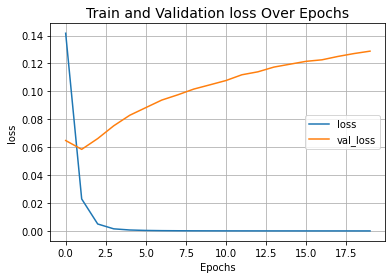

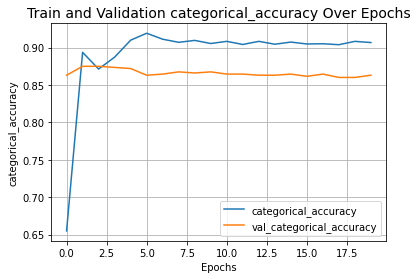

In [ ]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

In [ ]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

6/6 [==============================] - 0s 12ms/step - loss: 0.1394 - categorical_accuracy: 0.8793
Categorical accuracy on the test set: 87.93%.


# Reference
- https://medium.com/the-owl/imbalanced-multilabel-image-classification-using-keras-fbd8c60d7a4b
- https://link.springer.com/chapter/10.1007%2F978-3-642-40846-5_16
- Descriptions for algorithms, process, and evaluation metrics: https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
- Algorithms: https://scikit-learn.org/stable/modules/multiclass.html
- Classifier chain: https://arxiv.org/abs/1912.13405, https://www.cs.waikato.ac.nz/~eibe/pubs/chains.pdf
- Multilabel: https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
- Keras: https://keras.io/examples/nlp/multi_label_classification/